# 1. Schwebung

Wenn **zwei Schallwellen** mit **ähnlicher Frequenz** überlagert werden, entsteht eine **periodische Lautstärkeschwankung** – das Phänomen nennt man **akustische Schwebung**. Es handelt sich hierbei um **Amplitudenmodulation**.

Diese Schwebung nimmt das menschliche Ohr als ein **pulsierendes Auf- und Abschwellen des Tons** wahr.  

**Beispiel**:  
Wenn zwei Stimmgabeln mit leicht unterschiedlicher Frequenz (z. B. 440 Hz und 441 Hz) angeschlagen werden, hört man einen Ton, der **einmal pro Sekunde lauter und leiser** wird.

# 2. Mathematische Beschreibung

Nehmen wir zwei Schwingungen gleicher Amplitude $A$, aber mit leicht unterschiedlicher Frequenz $f_1$ und $f_2$:


$$y_1(t) = A \sin(2 \pi f_1 t)$$

$$
y_2(t) = A \sin(2 \pi f_2 t)
$$

Die **Überlagerung** (Superposition) ergibt:

$$
y(t) = y_1(t) + y_2(t)
$$

Mit trigonometrischen Umformungen folgt (Additiontheorem):

$$
y(t) = 2A \cos\left( 2\pi \frac{f_2 - f_1}{2}t \right) \cdot \sin\left( 2\pi \frac{f_1 + f_2}{2}t \right)
$$

Die **Frequenz der Hüllkurve** ist hierbei:

$$
f_\text{S} = \frac{|f_2-f_1|}{2}
$$

Die mittlere Frequenz ist der Überlagerung ist:

$$
f_\text{R} = \frac{|f_2+f_1|}{2}
$$

Die **Schwebungsfrequenz** $ f_\text{Schwebung} $ ergibt sich aus der **Differenz der beiden Einzelfrequenzen**:

$$
f_\text{Schwebung} = | f_2 - f_1 |
$$

# 3. Plot Beispiele

In der unterstehenden Zelle ist ein Code implementiert, der die Schwebung interaktiv darstellt.

## Zwei Signale
Für zwei Signale gleicher Amplitude wird auch die die **Hüllkurve** (in weiß gestrichelt) angezeigt. Es ist hierbei auch zu erkennen, dass sich dessen Frequenz als $f_\text{S} = \frac{|f_2-f_1|}{2}$ ergibt. Zudem ist noch zu erkennen, dass bei einem Phasenwinkel $\varphi = 0° $ zwischen den Frequenzen eine Konsinus-Schwingung entsteht. (Wie es in der oberen Formel $\cos\left( 2\pi \frac{f_2 - f_1}{2}t \right)$ beschrieben ist.) Bei Änderung der Phase zwischen den Signalen verschiebt sich die einfach die Hüllkurve, die Schwebung bleibt also bestehen.

## Drei Signale
Für drei Signale ergeben sich interessante Überlagerungunen die keine einfache mathematische Beschreibung mehr haben. Hier wird bei Veränderung der Phasen der Signale nicht einfach die resultierende Signalform verschoben, sondern sie verändert sich.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import Audio, display, HTML
import threading

FS = 44100
colors = ['#00FF00', '#FFFF00', '#00FFFF']

# --- Signalgenerator ---
def generate_waves(duration, params):
    t = np.linspace(0, duration, int(FS*duration), endpoint=False)
    waves = []
    for i in range(3):
        amp = params[i]['amp'].value
        freq = params[i]['freq'].value
        phase = params[i]['phase'].value
        wave = np.clip(amp * np.sin(2*np.pi*freq*t + phase), -1.0, 1.0)
        waves.append(wave.astype(np.float32))
    superposition = np.clip(sum(waves), -1.0, 1.0).astype(np.float32)
    return t, waves, superposition

# --- Plot-Funktion ---
plot_out = widgets.Output(layout=widgets.Layout(border='1px solid #333', padding='6px'))
audio_out = widgets.Output(layout=widgets.Layout(border='1px solid #333', padding='6px'))

def plot_waves(duration, params):
    t, waves, sup = generate_waves(duration, params)
    with plot_out:
        plot_out.clear_output(wait=True)
        plt.style.use("dark_background")
        fig, (ax_time, ax_fft) = plt.subplots(2,1, figsize=(12,6))

        # Zeitplot
        for i, wave in enumerate(waves):
            ax_time.plot(t, wave, label=f"Wave {i+1}", color=colors[i])
        ax_time.plot(t, sup, label="Superposition", color='red', linewidth=2)

        # plot the resultung wave
        if params[2]['amp'].value == 0.0 and params[0]['amp'].value == params[1]['amp'].value and abs((params[0]['freq'].value - params[1]['freq'].value )) < 10:
            amp = params[0]['amp'].value + params[1]['amp'].value
            freq = (params[0]['freq'].value - params[1]['freq'].value )/2.
            phase = (params[0]['phase'].value - params[1]['phase'].value) /2
            ax_time.plot(t, amp * np.sin(2*np.pi*freq*t + phase +np.pi/2), color='white', ls='--', linewidth=2) 
        
        ax_time.set_ylim(-1,1)
        ax_time.set_xlabel("Time (s)")
        ax_time.set_ylabel("Amplitude")
        ax_time.grid(True)
        #ax_time.legend(loc="upper right")

        # FFT
        N = len(t)
        for i, wave in enumerate(waves):
            fft_vals = np.fft.rfft(wave)
            fft_freqs = np.fft.rfftfreq(N, 1/FS)
            mag = 20*np.log10(np.abs(fft_vals)+1e-12) + 20*np.log10(1/(FS*duration/2))
            ax_fft.semilogx(fft_freqs, mag, color=colors[i], label=f"Wave {i+1}", linewidth=3.5)
        fft_vals_sup = np.fft.rfft(sup)
        fft_freqs_sup = np.fft.rfftfreq(N, 1/FS)
        mag_sup = 20*np.log10(np.abs(fft_vals_sup)+1e-12) + 20*np.log10(1/(FS*duration/2))
        ax_fft.semilogx(fft_freqs_sup, mag_sup, color='red', label="Superposition")


        freqs =[]
        for i in range(0, 3):
            p = params[i]
            freqs.append(p['freq'].value)

        ax_fft.set_xlim(int(min(freqs))*0.98, int(max(freqs))*1.02)   #ax_fft.set_xlim(20,20000)
        #ax_fft.set_xlim(20,20000)
        ax_fft.set_ylim(-70,0)
        ax_fft.set_xlabel("Frequency (Hz)")
        ax_fft.set_ylabel("Amplitude (dBFS)")
        ax_fft.grid(True, which='both', ls='--')
        ax_fft.legend(loc="upper right")
        plt.show()

# --- Audio-Funktionen ---
def play_wave(signal, autoplay=True):
    with audio_out:
        audio_out.clear_output(wait=True)
        display(Audio(data=signal, rate=FS, autoplay=autoplay, normalize=False))

def play_single(idx, params, duration, autoplay=True):
    _, waves, _ = generate_waves(duration, params)
    play_wave(waves[idx], autoplay=autoplay)

def play_superposition(params, duration, autoplay=True):
    _, _, sup = generate_waves(duration, params)
    play_wave(sup, autoplay=autoplay)

# --- Widgets ---
duration_slider = widgets.FloatSlider(value=5.0, min=0.5, max=5.0, step=0.05, description='Duration (s)', layout=widgets.Layout(width='420px'))
params = []
for i in range(3):
    if i == 0:
        amp_val, freq_val = 0.3, 440
    elif i == 1:
        amp_val, freq_val = 0.3, 441
    else:
        amp_val, freq_val = 0.0, 442

    amp = widgets.FloatSlider(value=amp_val, min=0.0, max=1.0, step=0.01, description=f"Amplitude {i+1}", layout=widgets.Layout(width='420px'))
    freq = widgets.FloatLogSlider(value=freq_val, min=np.log10(50), max=np.log10(10000), step=0.0000000000001, base=10, description=f"Freq {i+1} (Hz)", layout=widgets.Layout(width='420px'),readout_format='.0f')
    phase = widgets.FloatSlider(value=0.0, min=0, max=2*np.pi, step=0.01, description=f"Phase {i+1} (rad)", layout=widgets.Layout(width='420px'))
    params.append({'amp': amp, 'freq': freq, 'phase': phase})

btn_plot = widgets.Button(description="Plot", button_style='info')
btn_play_sup = widgets.Button(description="Play Superposition", button_style='danger')
chk_autoplay = widgets.Checkbox(value=True, description='Autoplay')

# --- Callbacks ---
def update_plot(_=None):
    plot_waves(duration_slider.value, params)
for p in params:
    for key in p:
        p[key].observe(update_plot, 'value')
btn_plot.on_click(update_plot)
btn_play_sup.on_click(lambda b: play_superposition(params, duration_slider.value, autoplay=chk_autoplay.value))

# Einzel-Play Buttons
play_buttons = []
for i in range(3):
    btn = widgets.Button(description=f"Play Wave {i+1}", style={'button_color': colors[i]})
    btn.on_click(lambda b, idx=i: play_single(idx, params, duration_slider.value, autoplay=chk_autoplay.value))
    play_buttons.append(btn)

# --- Layout ---
controls = widgets.VBox([
    duration_slider,
    widgets.HBox([p['amp'] for p in params]),
    widgets.HBox([p['freq'] for p in params]),
    widgets.HBox([p['phase'] for p in params]),
    widgets.HBox(play_buttons + [btn_play_sup, chk_autoplay]) #btn_plot
])

display(controls)
display(audio_out)
display(plot_out)

# Initial plot
update_plot()

Output(layout=Layout(border_bottom='1px solid #333', border_left='1px solid #333', border_right='1px solid #33…

Output(layout=Layout(border_bottom='1px solid #333', border_left='1px solid #333', border_right='1px solid #33…

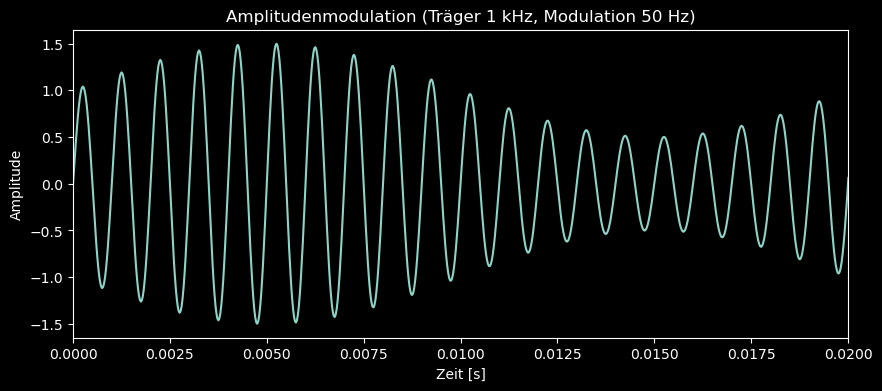

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
A_T = 1.0
A_M = 0.5
f_T = 1000.0  # Trägerfrequenz
f_M = 50.0    # Modulationsfrequenz
t = np.linspace(0, 0.05, 2000)

u = (A_T + A_M*np.sin(2*np.pi*f_M*t)) * np.sin(2*np.pi*f_T*t)

plt.figure(figsize=(10,4))
plt.plot(t, u)
plt.title("Amplitudenmodulation (Träger 1 kHz, Modulation 50 Hz)")
plt.xlabel("Zeit [s]")
plt.ylabel("Amplitude")
plt.xlim(0, 0.02)
plt.show()
